In [1]:
import matplotlib.pyplot as plt 
import scipy.misc
import numpy as np
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, Cropping2D
from keras.layers import MaxPooling2D, ZeroPadding2D, BatchNormalization, Activation, merge, GlobalAveragePooling2D
from keras.layers.merge import Add, Multiply, Average, Maximum, Concatenate, Dot
from keras.models import Model
from keras.utils.layer_utils import print_summary
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

from keras import __version__ as kv
from scipy import __version__ as sv
from matplotlib import __version__ as mv
from numpy import __version__ as nv

print kv
print sv
print mv
print nv

Using TensorFlow backend.


2.0.5
0.19.1
2.0.0
1.13.0


In [2]:
# Local files
import utils
reload(utils)
import utils2
reload(utils2)

<module 'utils2' from 'utils2.pyc'>

# Data

### Config

In [3]:
trained_model_dir = '/home/ubuntu/data/sar/experiment_crops_20170815/trained_models/4.2-as-FCN_with_visualisation_with_distance/'

In [4]:
train_dir = '/home/ubuntu/data/sar/experiment_crops_20170815/train/50x50/'
valid_dir = '/home/ubuntu/data/sar/experiment_crops_20170815/validate/50x50/'

In [5]:
input_shape = (50, 50, 1)
num_classes = 3

### Convert tif2png

Done in 1.0-mph_as_kd-baseline-simple_CNN_from_scratch.ipynb

### Add dist2land feature

In [6]:
train_crops, train_filename, train_feature, train_class, \
valid_crops, valid_filename, valid_feature, valid_class = utils.add_dist2land_experiment_crops_20170815()

In [7]:
print "training crops:", len(train_crops)
print "training features:", len(train_feature)
print "validation crops:", len(valid_filename)
print "validation features:", len(valid_feature)
print type(train_crops), type(train_crops[0]), train_crops[0].shape

training crops: 1996
training features: 1996
validation crops: 499
validation features: 499
<type 'list'> <type 'numpy.ndarray'> (50, 50)


In [8]:
# Reshape for keras format
np_train_class = np.array(train_class)
np_train_filename = np.array(train_filename)
np_train_crops = np.array(train_crops)
np_train_feature = np.array(train_feature)

np_valid_class = np.array(valid_class)
np_valid_filename = np.array(valid_filename)
np_valid_crops = np.array(valid_crops)
np_valid_feature = np.array(valid_feature)

np_train_crops = np.expand_dims(np_train_crops, axis=3)
np_train_feature = np.expand_dims(np_train_feature, axis=1)

np_valid_crops = np.expand_dims(np_valid_crops, axis=3)
np_valid_feature = np.expand_dims(np_valid_feature, axis=1)

In [9]:
print np_train_crops.shape
print np_train_feature.shape
print np_train_class.shape

print np_valid_crops.shape
print np_valid_feature.shape
print np_valid_class.shape

(1996, 50, 50, 1)
(1996, 1)
(1996, 3)
(499, 50, 50, 1)
(499, 1)
(499, 3)


# Experiments

## Baseline FCN (using https://github.com/asmith26/courses/blob/master/deeplearning1/nbs/lesson7.ipynb)

In [10]:
p = 0

classifier_input = Input(shape=input_shape)
dist2land_input = Input(shape=(1,), name='dist2land_input')


x = Conv2D(32, (3, 3), activation='relu', padding='same')(classifier_input)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# # Following based on https://github.com/asmith26/courses/blob/master/deeplearning1/nbs/lesson7.ipynb
x = BatchNormalization(axis=-1)(x)
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION

x = merge([x, dist2land_input], 'concat')

x = Conv2D(3,(3,3), padding='same')(x)
x = Dropout(p)(x)
x = GlobalAveragePooling2D()(x)
x = Activation('softmax')(x)


model_with_distance = Model(outputs=x, inputs=classifier_input)
model_with_distance.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: UserWarning:

The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.

/usr/local/lib/python2.7/dist-packages/keras/legacy/layers.py:460: UserWarning:

The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.



ValueError: "concat" mode can only merge layers with matching output shapes except for the concat axis. Layer shapes: [(None, 3, 3, 64), (None, 1)]

In [11]:
p = 0

classifier_input = Input(shape=input_shape)
dist2land_input = Input(shape=(1,))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(classifier_input)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# # Following based on https://github.com/asmith26/courses/blob/master/deeplearning1/nbs/lesson7.ipynb
x = BatchNormalization(axis=-1)(x)
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(3,(3,3), padding='same')(x)
x = Dropout(p)(x)
x = GlobalAveragePooling2D()(x)
m = Add()([dist2land_input, x])
out = Activation('softmax')(m)


model_with_distance = Model(inputs=[classifier_input, dist2land_input], outputs=out)
model_with_distance.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model_with_distance.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 50, 50, 1)     0                                            
____________________________________________________________________________________________________
conv2d_6 (Conv2D)                (None, 50, 50, 32)    320         input_2[0][0]                    
____________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)   (None, 25, 25, 32)    0           conv2d_6[0][0]                   
____________________________________________________________________________________________________
conv2d_7 (Conv2D)                (None, 25, 25, 64)    18496       max_pooling2d_5[0][0]            
___________________________________________________________________________________________

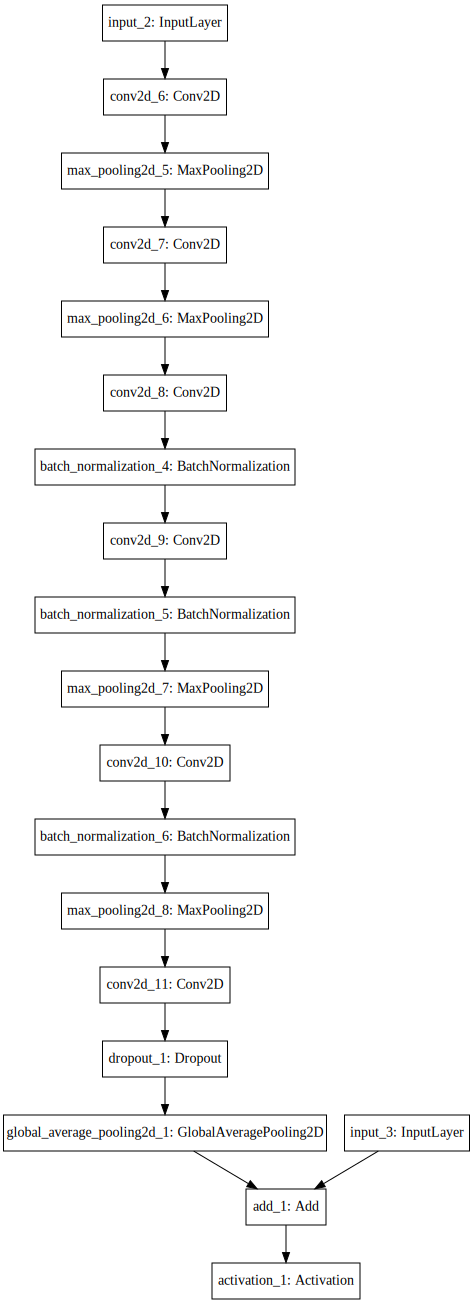

In [13]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_with_distance).create(prog='dot', format='svg'))

In [14]:
lr = 0.001
K.set_value(model_with_distance.optimizer.lr, lr)

model_with_distance.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=10,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 1996 samples, validate on 499 samples
Epoch 1/10
1996/1996 [==============================] - 31s - loss: 0.4325 - acc: 0.8392 - val_loss: 0.5996 - val_acc: 0.7856
Epoch 2/10
1996/1996 [==============================] - 32s - loss: 0.2654 - acc: 0.9048 - val_loss: 0.5542 - val_acc: 0.7455
Epoch 3/10
1996/1996 [==============================] - 31s - loss: 0.2165 - acc: 0.9228 - val_loss: 0.5158 - val_acc: 0.8778
Epoch 4/10
1996/1996 [==============================] - 31s - loss: 0.1802 - acc: 0.9349 - val_loss: 0.2459 - val_acc: 0.9178
Epoch 5/10
1996/1996 [==============================] - 34s - loss: 0.1319 - acc: 0.9514 - val_loss: 0.4352 - val_acc: 0.8938
Epoch 6/10
1996/1996 [==============================] - 44s - loss: 0.1224 - acc: 0.9569 - val_loss: 0.3964 - val_acc: 0.8677
Epoch 7/10
1996/1996 [==============================] - 44s - loss: 0.1075 - acc: 0.9614 - val_loss: 0.2192 - val_acc: 0.9319
Epoch 8/10
1996/1996 [==============================] - 43s - loss: 0.0

In [16]:
lr = 0.0001
K.set_value(model_with_distance.optimizer.lr, lr)

model_with_distance.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=5,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 1996 samples, validate on 499 samples
Epoch 1/5
1996/1996 [==============================] - 21s - loss: 0.0285 - acc: 0.9930 - val_loss: 0.1755 - val_acc: 0.9579
Epoch 2/5
1996/1996 [==============================] - 21s - loss: 0.0172 - acc: 0.9965 - val_loss: 0.1709 - val_acc: 0.9579
Epoch 3/5
1996/1996 [==============================] - 21s - loss: 0.0090 - acc: 0.9980 - val_loss: 0.1755 - val_acc: 0.9539
Epoch 4/5
1996/1996 [==============================] - 21s - loss: 0.0082 - acc: 0.9995 - val_loss: 0.1822 - val_acc: 0.9519
Epoch 5/5
1996/1996 [==============================] - 21s - loss: 0.0052 - acc: 0.9995 - val_loss: 0.1715 - val_acc: 0.9559


In [18]:
lr = 0.0001
K.set_value(model_with_distance.optimizer.lr, lr)

model_with_distance.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=3,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 1996 samples, validate on 499 samples
Epoch 1/3
1996/1996 [==============================] - 21s - loss: 0.0035 - acc: 1.0000 - val_loss: 0.1777 - val_acc: 0.9559
Epoch 2/3
1996/1996 [==============================] - 21s - loss: 0.0042 - acc: 0.9995 - val_loss: 0.1970 - val_acc: 0.9519
Epoch 3/3
1996/1996 [==============================] - 21s - loss: 0.0046 - acc: 0.9990 - val_loss: 0.1825 - val_acc: 0.9539


In [19]:
lr = 0.00001
K.set_value(model_with_distance.optimizer.lr, lr)

model_with_distance.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=3,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 1996 samples, validate on 499 samples
Epoch 1/3
1996/1996 [==============================] - 21s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.1847 - val_acc: 0.9519
Epoch 2/3
1996/1996 [==============================] - 21s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.1882 - val_acc: 0.9519
Epoch 3/3
1996/1996 [==============================] - 21s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.1895 - val_acc: 0.9519


No better than without distance.

### Adding another dense

In [21]:
p = 0

classifier_input = Input(shape=input_shape)
dist2land_input = Input(shape=(1,))
x2 = Dense(32)(dist2land_input)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(classifier_input)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# # Following based on https://github.com/asmith26/courses/blob/master/deeplearning1/nbs/lesson7.ipynb
x = BatchNormalization(axis=-1)(x)
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(3,(3,3), padding='same')(x)
x = Dropout(p)(x)
x = GlobalAveragePooling2D()(x)
m = Add()([x, x2])

out = Activation('softmax')(m)


model_with_distance_dense = Model(inputs=[classifier_input, dist2land_input], outputs=out)
model_with_distance_dense.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

ValueError: Operands could not be broadcast together with shapes (3,) (32,)